# FEATURE DESCRIPTON
Relevant Information:

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

Number of Instances: 45211 for bank-full.csv

Number of Attributes: 16 + output attribute.

Attribute information:

   Input variables:
   ##### bank client data:
   1. - age (numeric)
   2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. - education (categorical: "unknown","secondary","primary","tertiary")
   5. - default: has credit in default? (binary: "yes","no")
   6. - balance: average yearly balance, in euros (numeric) 
   7. - housing: has housing loan? (binary: "yes","no")
   8. - loan: has personal loan? (binary: "yes","no")
   ##### related with the last contact of the current campaign:
   9. - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10. - day: last contact day of the month (numeric)
  11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12. - duration: last contact duration, in seconds (numeric)
   ##### other attributes:
  13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15. - previous: number of contacts performed before this campaign and for this client (numeric)
  16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# LOAD DATA

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [8]:
df = pd.read_csv('data/bank-full.csv', delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# DATA PREPROCESSING

## DROP UNNECESSARY COLUMNS

In [10]:
df = df.drop(columns=['day', 'pdays', 'previous'])

In [6]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')

# EXPLORATORY DATA ANALYSIS

## NUMERICAL FEATURE

In [12]:
[i for i in df_num]

['age', 'balance', 'duration', 'campaign']

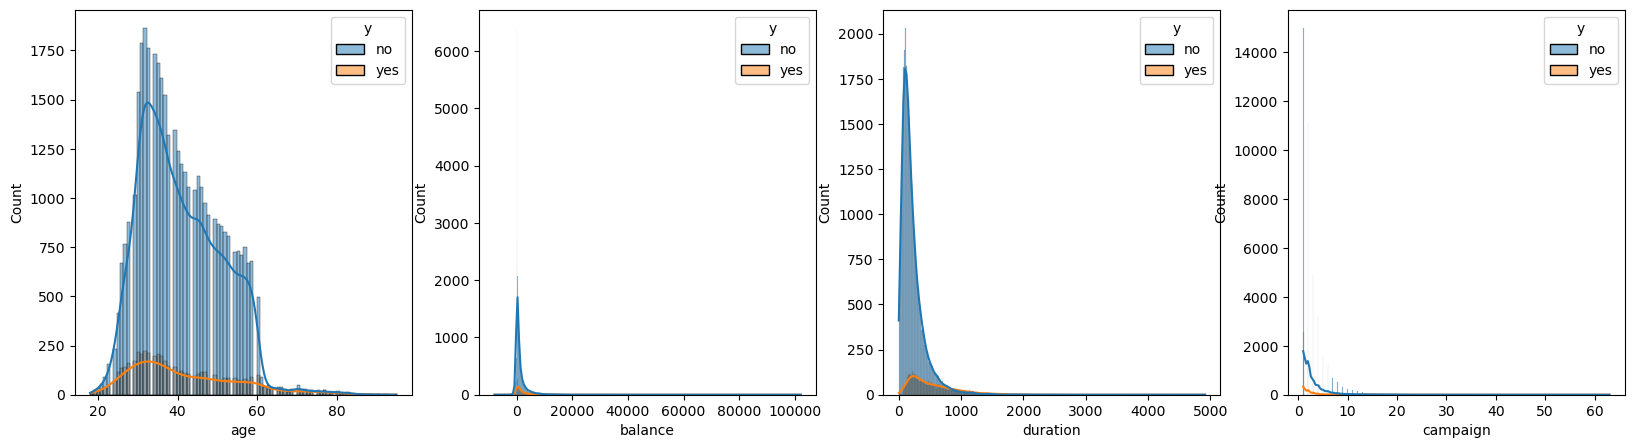

In [24]:
col = 0
fig, axes = plt.subplots(1,4, figsize=(20,5))
for i in df_num:
    sns.histplot(data=df, x=i, hue='y', kde=True, ax=axes[col])
    col+=1

<Axes: >

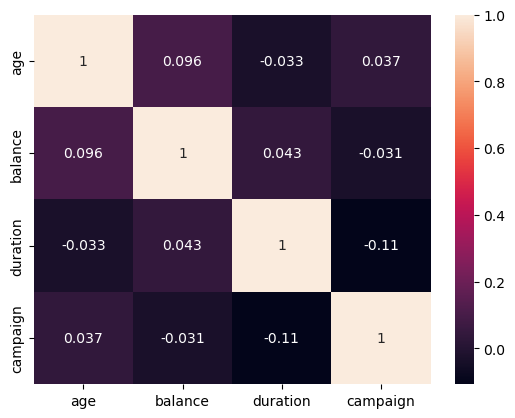

In [8]:
sns.heatmap(data=df_num.corr('spearman'), annot=True)

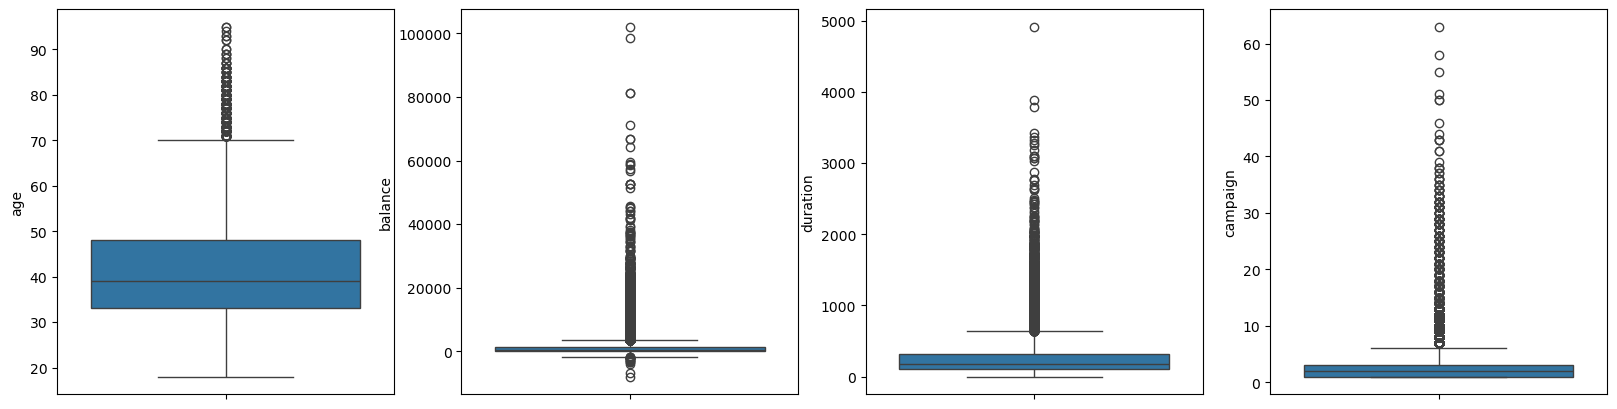

In [26]:
col = 0
fig, axes = plt.subplots(1,4, figsize=(20,5))
for i in df_num:
    sns.boxplot(data=df, y=i, ax=axes[col])
    col+=1

In [9]:
df.select_dtypes(exclude='object').describe()

,age,balance,duration,campaign
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841
std,10.618762,3044.765829,257.527812,3.098021
min,18.000000,-8019.000000,0.000000,1.000000
25%,33.000000,72.000000,103.000000,1.000000
50%,39.000000,448.000000,180.000000,2.000000
75%,48.000000,1428.000000,319.000000,3.000000
max,95.000000,102127.000000,4918.000000,63.000000


### Based on the above plots and descriptive statistics, we can conclude:
> 1. All feature have <b>right skew distribution (non normal distribution)</b>.
> 2. The strongest correlation between features is owned by <b>duration with campaign of -0.11</b> and <b>balance with age of 0.096</b>.
> 3. <b>Average age = 40.93, Youngest age = 18, Oldest age = 95</b>
> 4. <b>Average balance = 1362.27, Smallest balance = -8019, Biggest balance = 102127</b>
> 5. <b>Average duration = 258.16, Shortest duration = 0, Longest duration = 4918</b>
> 6. <b>Average campaign = 2.76, Least campaign = 1, Most frequent campaign = 63</b>

## CATEGORICAL FEATURE

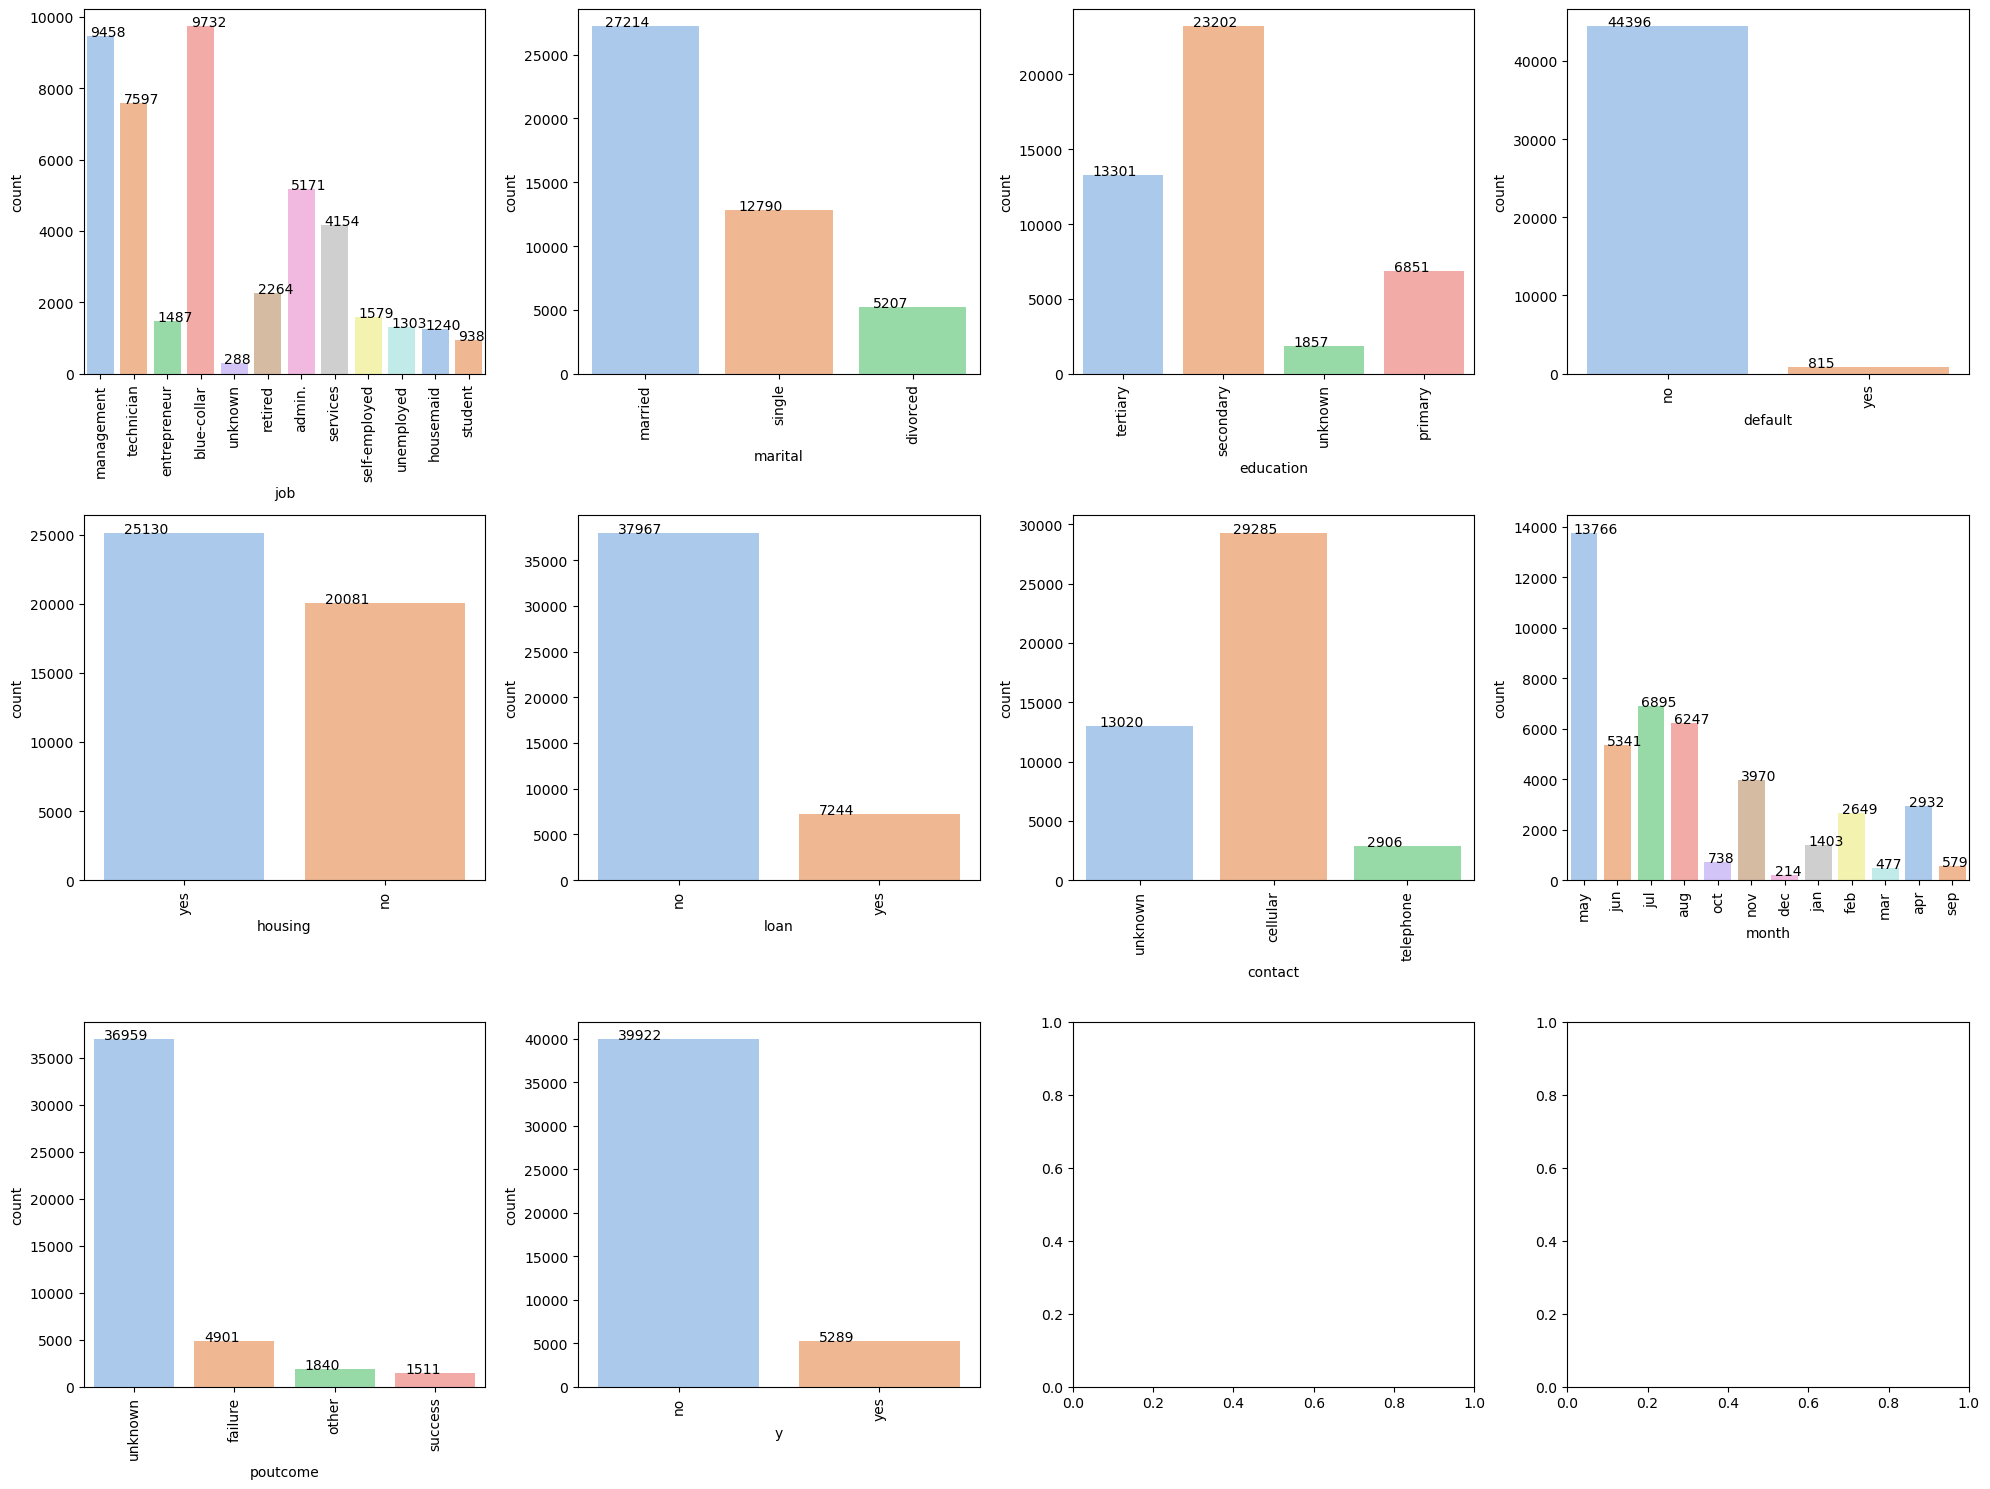

In [27]:
fig, ax = plt.subplots(3,4, figsize=(20,15))
col = 0
row = 0
for i in  df_cat:
    if col < 4:
        z = sns.countplot(data=df_cat, x=i, ax=ax[row][col], palette="pastel")
        for p in z.patches:
            z.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.02))

        plt.setp(ax[row][col].xaxis.get_majorticklabels(), rotation=90)
        col+=1
    else:
        col = 0
        row+=1
        z = sns.countplot(data=df_cat, x=i, ax=ax[row][col], palette="pastel")
        for p in z.patches:
            z.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.02))
        plt.setp(ax[row][col].xaxis.get_majorticklabels(), rotation=90)
        col+=1
fig.tight_layout()
plt.show()

### Based on the above plots and descriptive statistics, we can conclude:
> 1. <b>9732 customers job are blue-collar with.</b>
> 2. <b>27214 customers have married status.</b>
> 3. <b>23202 customers are secondary graduate.</b>
> 4. <b>44396 customers don't have a default.</b>
> 5. <b>Most customers already own a house as much as 25130.</b>
> 6. <b>Most customers do not have personal loans as much as 37967.</b>
> 7. <b>29285 customers are contacted through celullar.</b>
> 8. <b>Most customers were contacted in May as many as 13766.</b>
> 9. <b>Most poutcome are unknown as much as 36959.</b>
> 10. <b>A total of 39922 subscribed to term deposit and the rest don't.</b>

# FEATURE ENGINEERING

## FEATURE ENCODING

Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding.

### ONE HOT ENCODING

In [28]:
df_cat = pd.get_dummies(df_cat, prefix='job', columns=['job'])
df_cat = pd.get_dummies(df_cat, prefix='marital', columns=['marital'])
df_cat = pd.get_dummies(df_cat, prefix='default', columns=['default'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='housing', columns=['housing'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='loan', columns=['loan'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='poutcome', columns=['poutcome'])
df_cat = pd.get_dummies(df_cat, prefix='month', columns=['month'])
df_cat = pd.get_dummies(df_cat, prefix='contact', columns=['contact'])

In [29]:
df_cat.columns

Index(['education', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'default_yes', 'housing_yes', 'loan_yes', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'contact_cellular', 'contact_telephone',
       'contact_unknown'],
      dtype='object')

### ORDINAL ENCODING

In [30]:
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
df_cat['education_enc'] = OrdinalEncoder().fit_transform(df_cat[['education']])
df_cat = df_cat.drop(columns=['education'])

### TARGET ENCODING

In [31]:
df_cat['y'] = LabelEncoder().fit_transform(df_cat[['y']])

## FEATURE SELECTION

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. 
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

In [32]:
df_ft = pd.concat([df_num, df_cat], axis=1).reset_index(drop=True)

In [33]:
x = df_ft.drop(columns=['y']) #independent feature
y = df_ft['y'] #target

[0.11912345 0.12386635 0.2729118  0.07183536 0.0098188  0.00866847
 0.00448535 0.00407801 0.01070857 0.00691537 0.00558525 0.00717423
 0.00523815 0.0106237  0.0052717  0.0017441  0.00710678 0.00952
 0.00820122 0.00314022 0.02520791 0.01187876 0.01100366 0.0074856
 0.06088316 0.01775807 0.01158283 0.0087693  0.00438565 0.00613414
 0.00452386 0.00777612 0.01213243 0.01326585 0.0081923  0.00666722
 0.01125704 0.00962557 0.01034887 0.00473105 0.00842073 0.04195304]


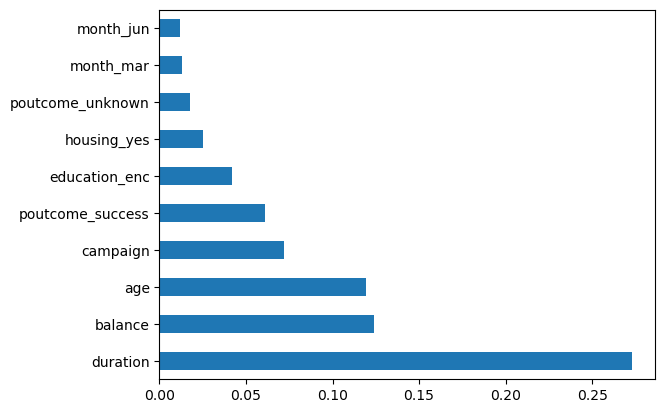

In [34]:
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
df_slc = pd.DataFrame()
df_slc = df_ft[feat_importances.nlargest(10).index]

In [36]:
df_slc['y'] = df_ft['y']

# MODELLING

### ANN
An artificial neural network (ANN) is a computational model that is inspired by the way biological neural networks work. These models are used to recognize patterns, cluster data, and make predictions.

ANNs are composed of a large number of interconnected processing nodes, or neurons, that can learn to recognize patterns of input data. The connections between nodes are called edges. Each node has a weight that determines the strength of the connection to other nodes.

In [40]:
X = df_slc.drop(columns='y')
y = df_slc['y']

In [41]:
# tarin test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #size test 20%

In [42]:
import tensorflow as tf

In [46]:
model_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_shape=[10], units=16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [47]:
model_ann.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_ann.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')
history = model_ann.fit(X_train,y_train, epochs=20, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.7928 - loss: 18.9062 - val_acc: 0.6584 - val_loss: 2.1756
Epoch 2/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.8420 - loss: 1.7953 - val_acc: 0.8691 - val_loss: 0.8059
Epoch 3/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.8555 - loss: 1.1749 - val_acc: 0.8829 - val_loss: 0.3823
Epoch 4/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.8459 - loss: 1.2679 - val_acc: 0.8857 - val_loss: 0.4487
Epoch 5/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.8598 - loss: 0.9051 - val_acc: 0.8514 - val_loss: 0.4809
Epoch 6/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.8677 - loss: 0.7771 - val_acc: 0.8824 - val_loss: 2.0487
Epoch 7/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.8645 - loss: 0.9921 - val_acc: 0.7774 - val_loss: 0.9056
Epoch 8/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.8691 - loss: 0.7506 - val_acc: 0.8265 - val_loss: 0.6095
Epoch 9/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - a

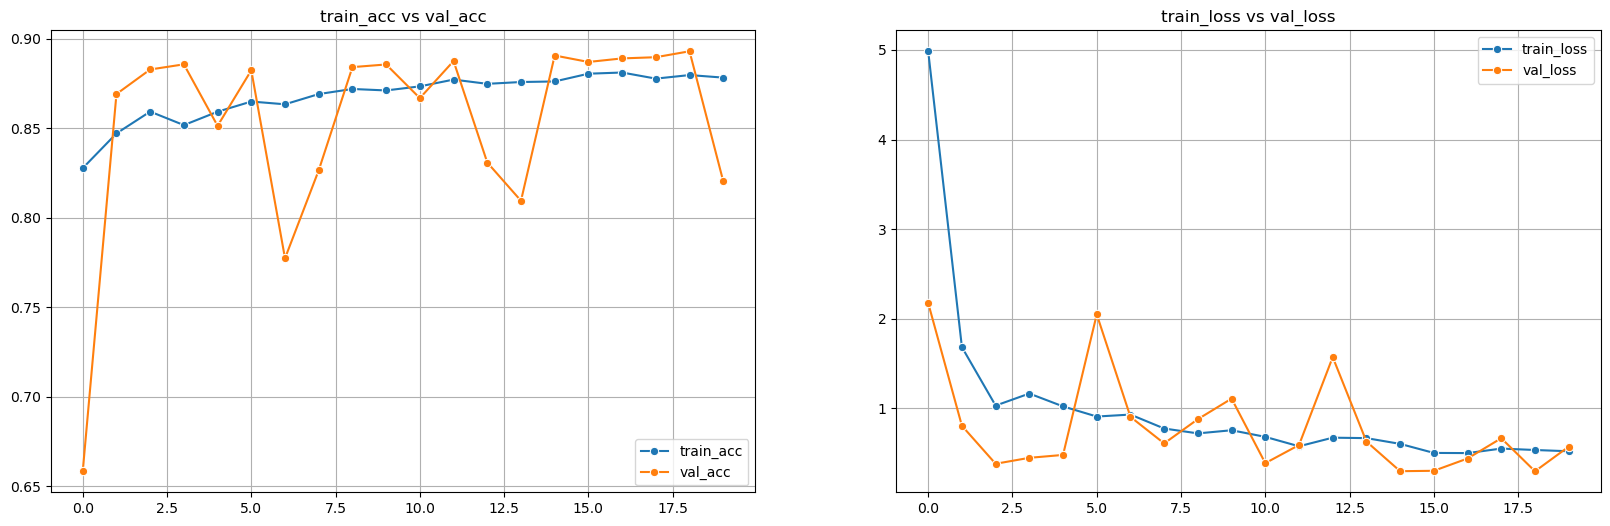

In [50]:
fig, axes = plt.subplots(1,2, figsize=[20,6])
sns.lineplot(data=history.history['acc'], ax=axes[0], marker='o', label='train_acc')
sns.lineplot(data=history.history['val_acc'], ax=axes[0], marker='o', label='val_acc')
axes[0].set_title('train_acc vs val_acc')


sns.lineplot(data=history.history['loss'], ax=axes[1], marker='o', label='train_loss')
sns.lineplot(data=history.history['val_loss'], ax=axes[1],marker='o', label='val_loss')
axes[1].set_title('train_loss vs val_loss')


axes[0].grid(True)
axes[1].grid(True)
plt.show()

In [52]:
y_pred = model_ann.predict(X_test)

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


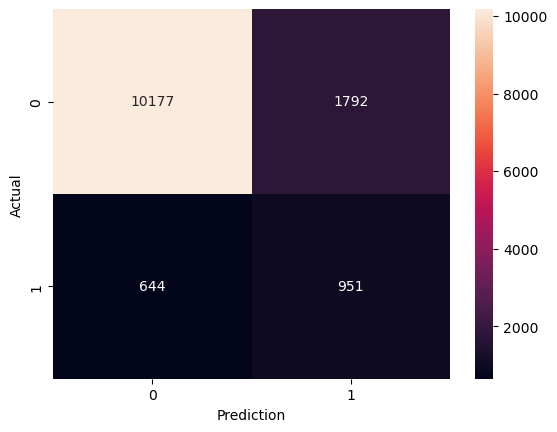

In [59]:
sns.heatmap(confusion_matrix(y_test, tf.round(y_pred)), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [61]:
print(classification_report(y_test, tf.round(y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     11969
           1       0.35      0.60      0.44      1595

    accuracy                           0.82     13564
   macro avg       0.64      0.72      0.67     13564
weighted avg       0.87      0.82      0.84     13564



### SMOTE

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [62]:
from imblearn.over_sampling import SMOTE

In [63]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [64]:
model_ann2= tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_shape=[10], units=16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [66]:
model_ann2.compile(metrics=['acc'], optimizer='adam', loss='binary_crossentropy')
history2 = model_ann2.fit(X_train_sm,y_train_sm, epochs=20, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - acc: 0.6065 - loss: 9.4978 - val_acc: 0.4979 - val_loss: 3.9131
Epoch 2/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.7060 - loss: 1.3568 - val_acc: 0.5843 - val_loss: 1.7309
Epoch 3/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.7363 - loss: 1.0812 - val_acc: 0.6368 - val_loss: 2.0489
Epoch 4/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.7555 - loss: 0.9138 - val_acc: 0.8311 - val_loss: 0.4683
Epoch 5/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7754 - loss: 0.7283 - val_acc: 0.7893 - val_loss: 0.6030
Epoch 6/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.7725 - loss: 0.7350 - val_acc: 0.8730 - val_loss: 0.3619
Epoch 7/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.7799 - loss: 0.6735 - val_acc: 0.8875 - val_loss: 0.3074
Epoch 8/20
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.7892 - loss: 0.6122 - val_acc: 0.6221 - val_loss: 1.4543
Epoch 9/20
1748/1748 ━━━━━━━━━━━━━━━━━━━

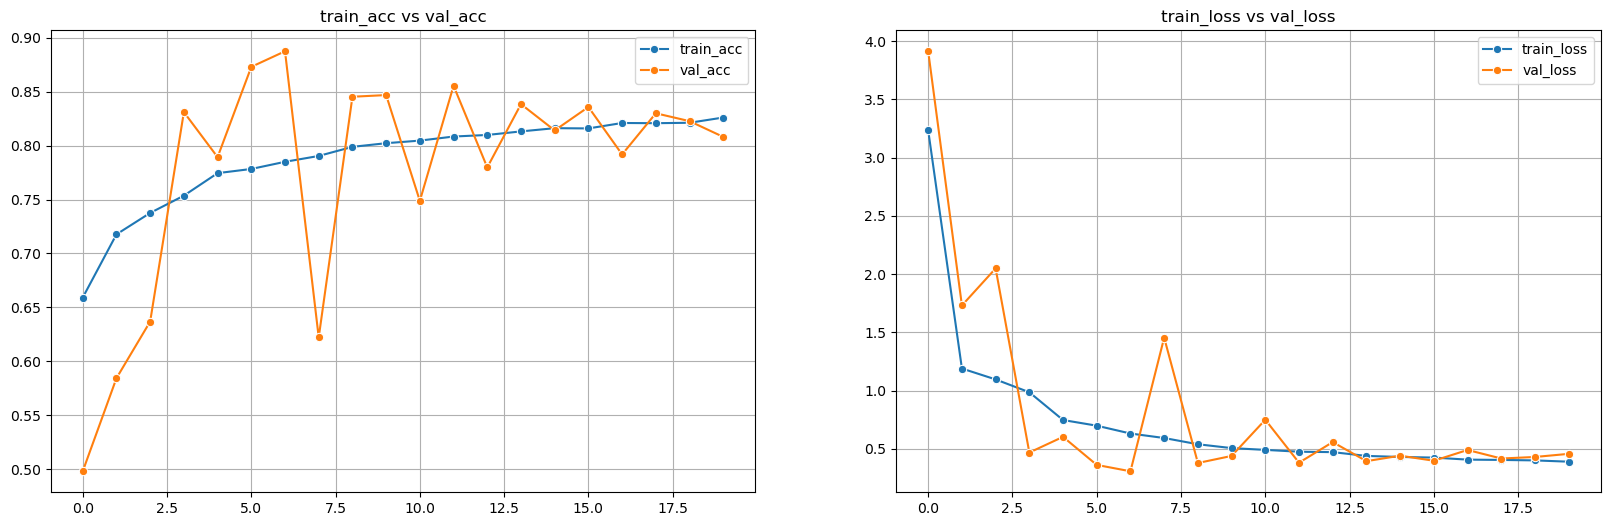

In [68]:
fig, axes = plt.subplots(1,2, figsize=[20,6])
sns.lineplot(data=history2.history['acc'], ax=axes[0], marker='o', label='train_acc')
sns.lineplot(data=history2.history['val_acc'], ax=axes[0], marker='o', label='val_acc')
axes[0].set_title('train_acc vs val_acc')


sns.lineplot(data=history2.history['loss'], ax=axes[1], marker='o', label='train_loss')
sns.lineplot(data=history2.history['val_loss'], ax=axes[1],marker='o', label='val_loss')
axes[1].set_title('train_loss vs val_loss')


axes[0].grid(True)
axes[1].grid(True)
plt.show()

In [67]:
y_pred2 = model_ann2.predict(X_test)

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


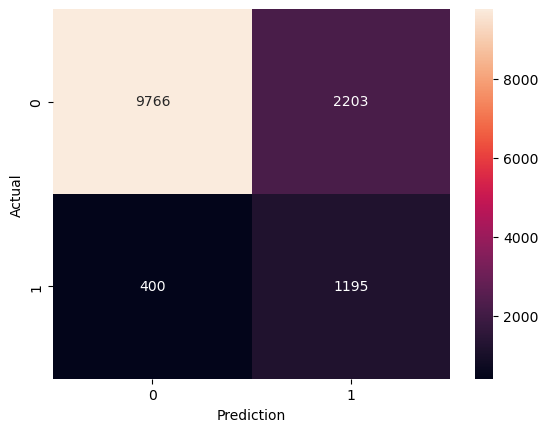

In [69]:
sns.heatmap(confusion_matrix(y_test, tf.round(y_pred2)), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [70]:
print(classification_report(y_test, tf.round(y_pred2)))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88     11969
           1       0.35      0.75      0.48      1595

    accuracy                           0.81     13564
   macro avg       0.66      0.78      0.68     13564
weighted avg       0.89      0.81      0.83     13564



# CONCLUSION
> 1. All feature have <b>right skew distribution (non normal distribution)</b>.
> 2. The strongest correlation between features is owned by <b>duration with campaign of -0.11</b> and <b>balance with age of 0.096</b>.
> 3. <b>Average age = 40.93, Youngest age = 18, Oldest age = 95</b>
> 4. <b>Average balance = 1362.27, Smallest balance = -8019, Biggest balance = 102127</b>
> 5. <b>Average duration = 258.16, Shortest duration = 0, Longest duration = 4918</b>
> 6. <b>Average campaign = 2.76, Least campaign = 1, Most frequent campaign = 63</7>
> 1. <b>9732 customers job are blue-collar with.<8b>
> 2. <b>27214 customers have married status.9/b>
> 3. <b>23202 customers are secondary graduate110</b>
> 4. <b>44396 customers don't have a defaul111.</b>
> 5. <b>Most customers already own a house as much as 2511120.</b>
> 6. <b>Most customers do not have personal loans as much as 3711367.</b>
> 7. <b>29285 customers are contacted through celu114lar.</b>
> 8. <b>Most customers were contacted in May as many as 1153766.</b>
> 9. <b>Most poutcome are unknown as much as 66959.A total of 39922 subscribed to term deposit and the rest don't.</b>pos17  aodIn this case we use recall to optimize because we need reduce false negative and the best model in this case is ann + smote because it give score recall of 75% which is larger than ann wiht imbalance data</b>.  e in this case.